In [20]:
import numpy as np
import ROOT
from math import sqrt, log

In [21]:
SIGNAL = "MHc-160_MA-120"
k = 5

In [22]:
def load_dataset(SIGNAL, k):
    mA = int(SIGNAL.split("_")[1].split("-")[1])
    sigma_dict = {65: 0.76,
                  85: 1.03,
                  90: 1.08,
                  95: 1.19,
                120: 1.58}
    sigma = sigma_dict[mA]
    
    col_sig = []
    f = ROOT.TFile(f"samples/2018/Skim3Mu__GraphNet__/{SIGNAL}/{SIGNAL}.root")
    tree = f.Get(f"{SIGNAL}_Central")
    for idx, evt in enumerate(tree, start=1):
        condition = (mA - k*sigma < evt.mass1 < mA + k*sigma) or (mA - k*sigma < evt.mass2 < mA + k*sigma)
        if not condition:
            continue
        col_sig.append([evt.scoreX, evt.scoreY, evt.scoreZ, evt.weight, 1.])
    col_sig = np.array(col_sig)

    col_VV = []
    f = ROOT.TFile(f"samples/2018/Skim3Mu__GraphNet__/{SIGNAL}/diboson.root")
    tree = f.Get("diboson_Central")
    for idx, evt in enumerate(tree, start=1):
        condition = (mA - k*sigma < evt.mass1 < mA + k*sigma) or (mA - k*sigma < evt.mass2 < mA + k*sigma)
        if not condition:
            continue
        col_VV.append([evt.scoreX, evt.scoreY, evt.scoreZ, evt.weight, 0.])
    col_VV = np.array(col_VV)

    col_ttX = []
    f = ROOT.TFile(f"samples/2018/Skim3Mu__GraphNet__/{SIGNAL}/ttX.root")
    tree = f.Get("ttX_Central")
    for idx, evt in enumerate(tree, start=1):
        condition = (mA - k*sigma < evt.mass1 < mA + k*sigma) or (mA - k*sigma < evt.mass2 < mA + k*sigma)
        if not condition:
            continue
        col_ttX.append([evt.scoreX, evt.scoreY, evt.scoreZ, evt.weight, 0.])
    col_ttX = np.array(col_ttX)
    
    col_conv = []
    f = ROOT.TFile(f"samples/2018/Skim3Mu__GraphNet__/{SIGNAL}/conversion.root")
    tree = f.Get("conversion_Central")
    for idx, evt in enumerate(tree, start=1):
        condition = (mA - k*sigma < evt.mass1 < mA + k*sigma) or (mA - k*sigma < evt.mass2 < mA + k*sigma)
        if not condition:
            continue
        col_conv.append([evt.scoreX, evt.scoreY, evt.scoreZ, evt.weight, 0.])
    col_conv = np.array(col_conv)

    col_fake = []
    f = ROOT.TFile(f"samples/2018/Skim3Mu__GraphNet__/{SIGNAL}/nonprompt.root")
    tree = f.Get("nonprompt_Central")
    for idx, evt in enumerate(tree, start=1):
        condition = (mA - k*sigma < evt.mass1 < mA + k*sigma) or (mA - k*sigma < evt.mass2 < mA + k*sigma)
        if not condition:
            continue
        col_fake.append([evt.scoreX, evt.scoreY, evt.scoreZ, evt.weight, 0.])
    col_fake = np.array(col_fake)

    col_others = []
    f = ROOT.TFile(f"samples/2018/Skim3Mu__GraphNet__/{SIGNAL}/others.root")
    tree = f.Get("others_Central")
    for idx, evt in enumerate(tree, start=1):
        condition = (mA - k*sigma < evt.mass1 < mA + k*sigma) or (mA - k*sigma < evt.mass2 < mA + k*sigma)
        if not condition:
            continue
        col_others.append([evt.scoreX, evt.scoreY, evt.scoreZ, evt.weight, 0.])
    col_others = np.array(col_others)
    
    col_bkg = np.concatenate([col_VV, col_ttX, col_others, col_conv, col_fake], axis=0)
    
    return col_sig, col_bkg

In [23]:
def scale_signal(col_sig, col_bkg):
    hX_sig = ROOT.TH1D("hX_sig", "", 100, 0., 1.)
    hY_sig = ROOT.TH1D("hY_sig", "", 100, 0., 1.)
    hZ_sig = ROOT.TH1D("hZ_sig", "", 100, 0., 1.)
    hX_bkg = ROOT.TH1D("hX_bkg", "", 100, 0., 1.)
    hY_bkg = ROOT.TH1D("hY_bkg", "", 100, 0., 1.)
    hZ_bkg = ROOT.TH1D("hZ_bkg", "", 100, 0., 1.)
    
    for evt in col_sig:
        scoreX, scoreY, scoreZ, weight = tuple(evt[:4])
        hX_sig.Fill(scoreX, weight)
        hY_sig.Fill(scoreY, weight)
        hZ_sig.Fill(scoreZ, weight)
        
    for evt in col_bkg:
        scoreX, scoreY, scoreZ, weight = tuple(evt[:4])
        hX_bkg.Fill(scoreX, weight)
        hY_bkg.Fill(scoreY, weight)
        hZ_bkg.Fill(scoreZ, weight)
    
    print(hX_sig.Integral())
    print(hX_bkg.Integral())
    sigScaleFactor = hX_bkg.Integral() / hX_sig.Integral()
    return sigScaleFactor

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [25]:
col_sig, col_bkg = load_dataset(SIGNAL, k=5)
sigScaleFactor = scale_signal(col_sig, col_bkg)
col_sig[:, 3] = col_sig[:, 3]*sigScaleFactor

col_bkg = shuffle(col_bkg, random_state=42)
events = np.concatenate([col_sig, col_bkg], axis=0)
events = shuffle(events, random_state=42)

35.11459326343838
65.95652442976662


In [26]:
X, weights, y = events[:, :3], events[:, 3], events[:, 4]
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X, y, weights, test_size=0.4, random_state=42)

In [64]:
clf = GradientBoostingClassifier(n_estimators=10, max_depth=2)
clf.fit(X_train, y_train, sample_weight=sw_train)

GradientBoostingClassifier(max_depth=2, n_estimators=10)

0.221 0.119


Warning in <TROOT::Append>: Replacing existing TH1: hSigTrain (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hBkgTrain (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hSigTest (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hBkgTest (Potential memory leak).
Warning in <TH1D::KolmogorovTest>: Detected bins with negative weights, these have been ignored and output might be skewed. Reduce number of bins for histogram?


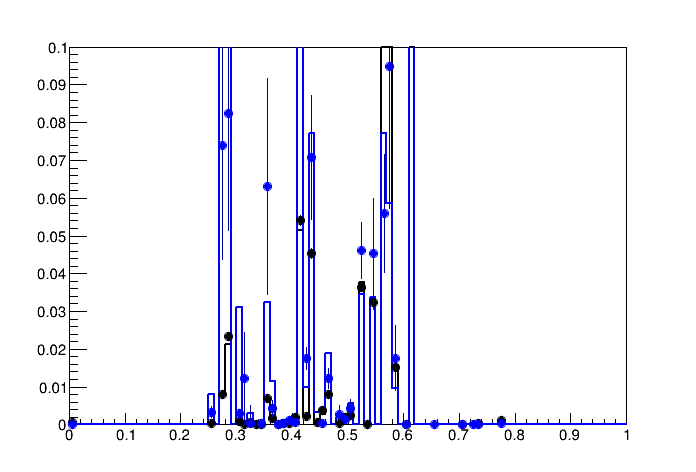

In [65]:
hSigTrain = ROOT.TH1D("hSigTrain", "", 100, 0., 1.)
hBkgTrain = ROOT.TH1D("hBkgTrain", "", 100, 0., 1.)
hSigTest = ROOT.TH1D("hSigTest", "", 100, 0., 1.)
hBkgTest = ROOT.TH1D("hBkgTest", "", 100, 0., 1.)

y_pred = clf.predict_proba(X_train)
for score, weight, label in zip(y_pred, sw_train, y_train):
    if label == 0: hBkgTrain.Fill(score[1], weight)
    else: hSigTrain.Fill(score[1], weight)

y_pred = clf.predict_proba(X_test)
for score, weight, label in zip(y_pred, sw_test, y_test):
    if label == 0: hBkgTest.Fill(score[1], weight)
    else: hSigTest.Fill(score[1], weight)

hSigTrain.SetLineColor(ROOT.kBlack)
hBkgTrain.SetLineColor(ROOT.kBlue)
hSigTrain.SetLineWidth(2)
hBkgTrain.SetLineWidth(2)
hSigTest.SetMarkerStyle(20)
hBkgTest.SetMarkerStyle(20)
hSigTest.SetMarkerSize(1)
hBkgTest.SetMarkerSize(1)
hSigTest.SetMarkerColor(ROOT.kBlack)
hBkgTest.SetMarkerColor(ROOT.kBlue)
hSigTrain.SetStats(0)
hBkgTrain.SetStats(0)

hSigTrain.Scale(1./hSigTrain.Integral())
hBkgTrain.Scale(1./hBkgTrain.Integral())
hSigTest.Scale(1./hSigTest.Integral())
hBkgTest.Scale(1./hBkgTest.Integral())

ksProbSig = hSigTrain.KolmogorovTest(hSigTest, option="X")
ksProbBkg = hBkgTrain.KolmogorovTest(hBkgTest, option="X")

print(ksProbSig, ksProbBkg)

hSigTrain.GetYaxis().SetRangeUser(0., 0.1)
c = ROOT.TCanvas()
#c.SetLogy()
c.cd()
hSigTrain.Draw("hist")
hBkgTrain.Draw("hist&same")
hSigTest.Draw("p&same")
hBkgTest.Draw("p&same")
c.Draw()

4.006357558712715
56 4.982008212422226
0.2435256063422852


Warning in <TROOT::Append>: Replacing existing TH1: hSig (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hBkg (Potential memory leak).


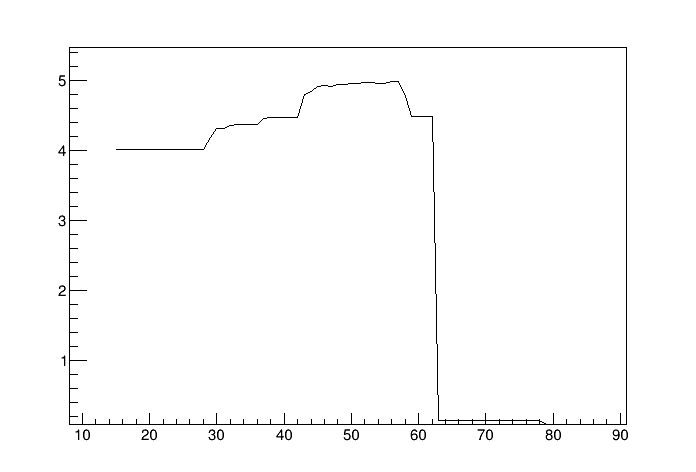

In [66]:
hSig = ROOT.TH1D("hSig", "", 100, 0., 1.)
hBkg = ROOT.TH1D("hBkg", "", 100, 0., 1.)
y_pred = clf.predict_proba(X)
for score, weight, label in zip(y_pred, weights, y):
    if label == 0: hBkg.Fill(score[1], weight)
    else: hSig.Fill(score[1], weight)
hSig.Scale(1./sigScaleFactor)

from math import sqrt, log

nBins = hSig.GetNbinsX()
nSig = hSig.Integral(0, nBins+1)
nBkg = hBkg.Integral(0, nBins+1)
initMetric = sqrt(2*((nSig+nBkg)*log(1+nSig/nBkg)-nSig))
print(initMetric)

graph = ROOT.TGraph()
bestCut = 0
bestMetric = initMetric
for bin in range(15, nBins-15):
    nSig = hSig.Integral(bin, nBins+1)
    nBkg = hBkg.Integral(bin, nBins+1)
    try:
        metric = sqrt(2*((nSig+nBkg)*log(1+nSig/nBkg)-nSig))
        graph.AddPoint(bin, metric)
    except:
        print(bin, nSig, nBkg)
        continue
    if metric > bestMetric:
        bestCut = bin
        bestMetric = metric

print(bestCut, bestMetric)
print((bestMetric-initMetric) / initMetric)

c = ROOT.TCanvas()
c.cd()
graph.Draw()
c.Draw()

In [60]:
50  3   0.212   0.183   33%     50  2   0.272   0.157   28%
40  3   0.283   0.171   33%     40  2   0.154   0.123   28%
30  3   0.156   0.134   32%     30  2   0.239   0.231   28%
20  3   0.242   0.339   39%     20  2   0.262   0.187   27%
10  3   0.169   0.33    28%     10  2   0.221   0.199   24%

SyntaxError: invalid syntax (712065121.py, line 1)